In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import string
import re
import nltk
import warnings
warnings.filterwarnings("ignore")
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [3]:
recs = pd.read_csv('cleaned_recs.csv')[['Document File Name ', 'Recommendation text']].dropna(0, 'all')
# df = df[['Recommendation text']].dropna().reset_index(drop = True)
file_mapping = pd.read_csv("file_mapping.csv")

In [4]:
merged = pd.merge(recs, file_mapping, left_on="Document File Name ", right_on="original_name", how='inner')

In [5]:
test = merged.loc[(merged.indexed_name == '12.pdf') | (merged.indexed_name == '9.pdf')]
train = merged.loc[~((merged.indexed_name == '12.pdf') | (merged.indexed_name == '9.pdf'))]

In [6]:
train.shape[0], test.shape[0]

(100, 9)

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/shubham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Sentence Embeddings

In [8]:
import seaborn as sns
from sentence_transformers import SentenceTransformer

sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [9]:
sentences = train['Recommendation text'].to_numpy()
sentence_embeddings = sbert_model.encode(sentences)

In [10]:
sentence_embeddings.shape

(100, 768)

### K-Means Clustering

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


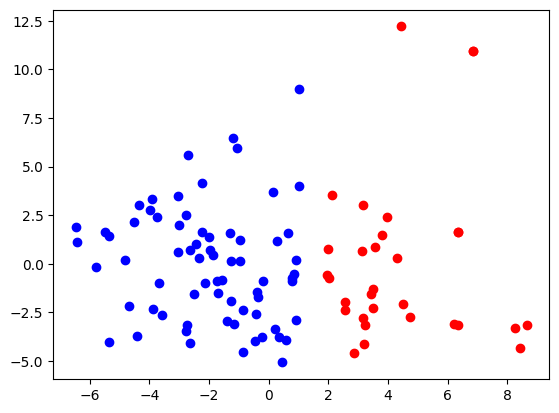

In [11]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(sentence_embeddings)

# Use PCA to reduce the embeddings to 2 dimensions
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(sentence_embeddings)

# Create a scatter plot of the reduced embeddings with different colors for each cluster
colors = ['red', 'blue', 'green', 'yellow', 'black', 'cyan']
for i in range(num_clusters):
    plt.scatter(reduced_embeddings[kmeans.labels_ == i, 0], 
                reduced_embeddings[kmeans.labels_ == i, 1], 
                c=colors[i], label=f'Cluster {i}')

### Elbow method for ideal number of clusters

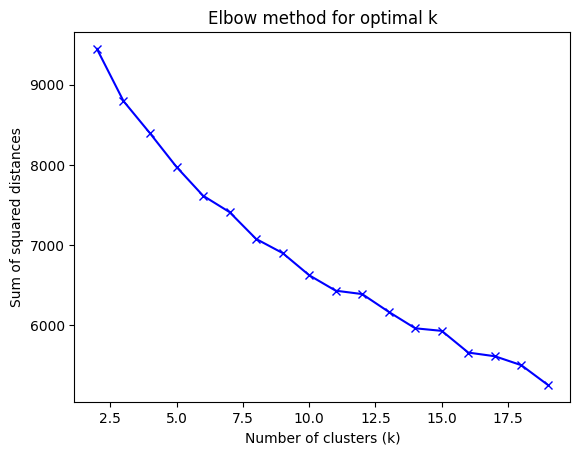

In [12]:
range_n_clusters = range(2, 20)

# Compute the sum of squared distances for each k
ssd = []
for k in range_n_clusters:
    kmeans_temp = KMeans(n_clusters=k, random_state=0).fit(sentence_embeddings)
    ssd.append(kmeans_temp.inertia_)

# Plot the elbow curve
plt.plot(range_n_clusters, ssd, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method for optimal k')
plt.show()

### Word Frequency in Recs

In [13]:
from collections import Counter
import re
from nltk.corpus import stopwords

# Define a list of sentences
sentences = list(train['Recommendation text'])

# Concatenate all sentences into a single string
text = ' '.join(sentences)

# Remove punctuation and convert to lowercase
text = re.sub(r'[^\w\s]', '', text).lower()

# Split the text into words
words = text.split()

# Count the occurrence of each word
word_counts = Counter(words)

# Get the 10 most common words
top_words = word_counts.most_common(20)

top_words

[('and', 133),
 ('the', 126),
 ('to', 82),
 ('should', 59),
 ('that', 50),
 ('of', 50),
 ('for', 38),
 ('in', 32),
 ('a', 29),
 ('be', 26),
 ('as', 24),
 ('with', 24),
 ('cybersecurity', 21),
 ('names', 18),
 ('ensure', 17),
 ('cyber', 17),
 ('their', 16),
 ('it', 15),
 ('cve', 14),
 ('on', 14)]

### Sentence Filter

In [14]:
# Define a list of sentences
sentences = list(train['Recommendation text'])

# Define the regex pattern for modal verbs
modal_pattern = r'\b(can|could|may|might|must|shall|should|will|would|ensur)\b'

# Filter the sentences that contain modal verbs
modal_sentences = [sentence for sentence in sentences if re.search(modal_pattern, sentence)]
non_modal_sentences = [sentence for sentence in sentences if not re.search(modal_pattern, sentence)]

print(len(modal_sentences)/len(sentences))

0.72


### Cosine Similarity

In [15]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

matrix = np.identity(sentence_embeddings.shape[0])
for i in range(matrix.shape[0]):
  for j in range(i,matrix.shape[0]):
    matrix[i][j] = cosine(sentence_embeddings[i],sentence_embeddings[j])
    matrix[j][i] = matrix[i][j]

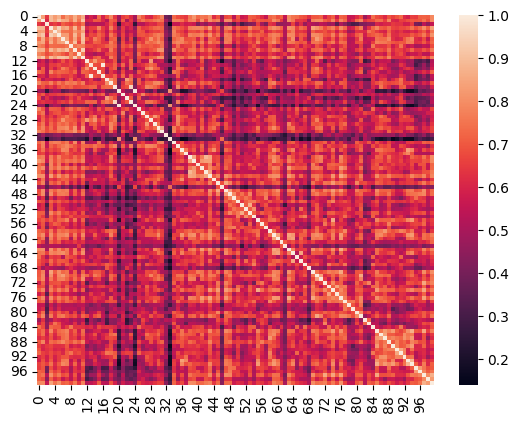

In [16]:
ax = sns.heatmap(matrix)

In [17]:
cluster1, cluster2 = kmeans.cluster_centers_

In [18]:
training_cosines = [max(cosine(cluster1, embedd), cosine(cluster2, embedd)) for embedd in sentence_embeddings]

(array([ 1.,  1.,  1.,  4.,  4.,  7., 21., 25., 26., 10.]),
 array([0.46781918, 0.51309556, 0.5583719 , 0.60364825, 0.64892459,
        0.69420093, 0.73947728, 0.78475368, 0.83003002, 0.87530637,
        0.92058271]),
 <BarContainer object of 10 artists>)

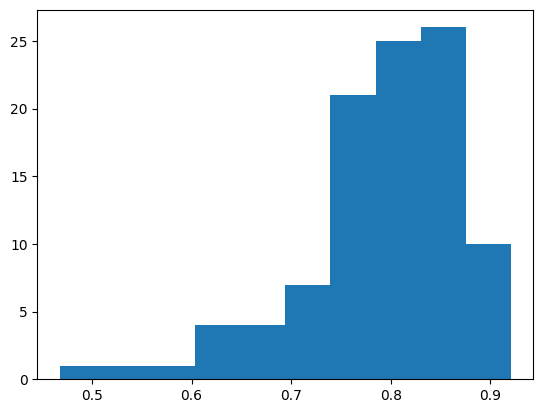

In [19]:
plt.hist(training_cosines)

### Testing

In [20]:
from tika import parser

raw12 = parser.from_file('12.pdf')
raw9 = parser.from_file('9.pdf')

2023-05-19 05:10:23,102 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to /tmp/tika-server.jar.
2023-05-19 05:10:55,844 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /tmp/tika-server.jar.md5.
2023-05-19 05:10:57,233 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [21]:
text12 = raw12['content'].replace('\n','')
text9 = raw9['content'].replace('\n','')

text = text12 + ' ' + text9

In [67]:
test_sentences = nltk.sent_tokenize(text)

modal_pattern = r'\b(can|could|may|might|must|shall|should|will|would|ensur)\b'

filtered_test_sentences = [sentence for sentence in test_sentences]# if re.search(modal_pattern, sentence)]

In [68]:
relevant = []
distances = []

for sentence in filtered_test_sentences:
  embedd = sbert_model.encode(sentence)
  distances.append(max(cosine(cluster1, embedd), cosine(cluster2, embedd)))

In [69]:
sorted_idx = sorted(range(len(distances)), key=lambda k: distances[k], reverse=True)
sorted_sentences = np.array(filtered_test_sentences)[sorted_idx]

In [70]:
sorted_distances = sorted(distances, reverse=True)

preds = pd.DataFrame(list(zip(sorted_sentences, sorted_distances)), columns=['Sentence', 'Cosine'])

In [82]:
import difflib

def retrieve_sentence_index(sentence, sentence_list):
    # Tokenize the sentences
    sentence_tokens = sentence.split()
    sentence_list_tokens = [s.split() for s in sentence_list]
    
    # Calculate the similarity between the sentences
    similarity_scores = [difflib.SequenceMatcher(None, sentence_tokens, s).ratio() for s in sentence_list_tokens]
    
    # Find the index of the most similar sentence
    max_similarity_index = similarity_scores.index(max(similarity_scores))
    
    return max_similarity_index

In [72]:
test_indices = [retrieve_sentence_index(sentence, preds['Sentence']) for sentence in test.iloc[:, 1]]
test_preds = preds.iloc[test_indices, :]
final = test_preds.set_index(100 * test_preds.index/len(preds)).sort_index()

In [73]:
final

,Sentence,Cosine
0.396825,Domestic and foreign policy oversight by compe...,0.880922
0.925926,Agencies should identify the CVE entries that ...,0.870656
2.513228,Federal departments and agencies should period...,0.827922
3.306878,3http://cve.mitre.org/http://icat.nist.gov/htt...,0.818125
4.894180,"Intelligence oversight, including an “intellig...",0.805436
6.216931,Such oversight also should provide assess-ment...,0.790296
6.613757,Since it is infeasible for an organization to ...,0.789907
16.402116,Operational oversight with appropriate respons...,0.740288
16.666667,Technical oversight that includes a “technical...,0.738921


In [74]:
final.Cosine.mean()

0.8069414496421814

In [57]:
test.iloc[:, [1, 3]]

,Recommendation text,indexed_name
36,Federal departments and agencies should period...,12.pdf
37,NIST recommends monitoring systems for vulnera...,12.pdf
38,Agencies should identify the CVE entries that ...,12.pdf
39,Since it is infeasible for an organization to ...,12.pdf
101,Domestic and foreign policy oversight by compe...,9.pdf
102,Technical oversight that includes a “technical...,9.pdf
103,Such oversight also should provide assess- men...,9.pdf
104,Operational oversight with appropriate respons...,9.pdf
105,"Intelligence oversight, including an “intellig...",9.pdf


In [68]:
with open("workflow2_preds.txt", 'w') as f:
    pass 
for i in range(25):
    if i not in test_indices:
        with open("workflow2_preds.txt", 'a') as f:
            f.write(f"{preds.iloc[i, 0]}\n\n")

### Potential Future Steps:

1. Choose any BERT model (RoBERTa?).
2. Get embeddings for modal verbs.
3. Use them to extract general recommendations.
4. Train a recommendation classifier (cyber/non-cyber).
5. Steps 3-4 allow for evalutions to be more systematic.

#TODO this pipeline on non-recs

In [ ]:
def extract_modal_sentences(corpus):
    modal_verbs = ["can", "could", "may", "might", "must", "shall", "should", "will", "would"]
    modal_sentences = []
    for sentence in corpus:
        for word in sentence:
            if word.lower() in modal_verbs:
                modal_sentences.append(sentence)
                break
    return modal_sentences